In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, fbeta_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
import seaborn  as sns
import shap

RANDOM_STATE = 42
TEST_SIZE=0.05

🔹 Введение
Цель проекта — разработка модели машинного обучения для предсказания риска сердечного приступа на основе медицинских, поведенческих и биохимических данных пациентов. Исследование проводится в рамках подготовки сервиса, который будет обрабатывать входные данные и возвращать предсказания.

Исходные данные представляют собой информацию о пациентах, включая антропометрию, вредные привычки, хронические заболевания, лабораторные показатели и артериальное давление. Целевая переменная — бинарный риск поражения сердца (0 — низкий, 1 — высокий).

## Загрузка и исследование данных

In [733]:
def preprocess_data(df):
    """
    Функция для базовой предобработки данных
    
    Параметры:
    df (pandas.DataFrame): Входной датафрейм
    
    Возвращает:
    pandas.DataFrame: Предобработанный датафрейм
    """
    # Создаем копию датафрейма
    df_processed = df.copy()
    
    # 1. Заменим названия столбцов на snake_case
    for col in df_processed.columns:
        df_processed.rename(columns={col: col.strip().replace(' ',"_")}, inplace=True)
    
    # 2. Обработка пропущенных значений
    # Удаление строк, где все значения отсутствуют
    #df_processed.dropna(how='all', inplace=True)
    
    # 3. Приведение названий колонок к нижнему регистру
    df_processed.columns = df_processed.columns.str.lower()
    
    # 4. Изучаем количественные переменные
    numeric_columns = df_processed.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        count_NA_num = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_num} \n")
        
    # 5. Изучаем категориальные значения
    categorical_columns = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        count_NA_cat = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_cat}")
        print(f"Уникальные значения {col}: {df_processed[col].unique()} \n")
    
    # 6. Удаление дубликатов
    df_processed.drop_duplicates(inplace=True)
    
    
    # 7. Удаление пробелов в строковых значениях
    for col in categorical_columns:
        df_processed[col] = df_processed[col].str.strip()
    
    return df_processed

In [752]:
def explore_data(df, discrete_columns=[]):
    """
    Функция для проведения исследовательского анализа данных
    
    Параметры:
    df (pandas.DataFrame): Входной датафрейм
    
    Возвращает:
    dict: Словарь с результатами анализа
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    results = {}
    
    # 1. Базовая информация о датафрейме
    print("="*50)
    print("ОБЩАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ")
    print("="*50)
    print(f"\nРазмер датафрейма: {df.shape}")
    print(f"\nИнформация о датафрейме:")
    df.info()
    
    # 2. Статистический анализ
    print("\n", "="*50)
    print("СТАТИСТИЧЕСКИЙ АНАЛИЗ")
    print("="*50)
    
    # Числовые колонки
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_columns) > 0:
        print("\nСтатистика по числовым колонкам:")
        display(df[numeric_columns].describe())
        
        # Корреляционная матрица
        if len(numeric_columns) != 1:
            plt.figure(figsize=(15, 15))
            sns.heatmap(df[numeric_columns].corr(method='kendall').round(1), annot=True, cmap='coolwarm')
            plt.title('Корреляционная матрица')
            plt.show()
    
    # Категориальные колонки
    categorical_columns = df.select_dtypes(include=['object', 'bool', 'category']).columns
    if len(categorical_columns) > 0:
        print("\nСтатистика по категориальным колонкам:")
        for col in categorical_columns:
            print(f"\nРаспределение значений в колонке {col}:")
            display(df[col].value_counts())
            print(f"Количество уникальных значений: {df[col].nunique()}")
    
    # 3. Пропущенные значения
    print("\n", "="*50)
    print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
    print("="*50)
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_data = pd.concat([missing_values, missing_percent], axis=1)
    missing_data.columns = ['Количество пропусков', 'Процент пропусков']
    print("\nИнформация о пропущенных значениях:")
    display(missing_data[missing_data['Количество пропусков'] > 0])
    
    # 4. Визуализация распределений
    print("\n", "="*50)
    print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ")
    print("="*50)
    
        
    for col in numeric_columns:
        if col not in discrete_columns:
            plt.figure(figsize=(10, 4))
        
            # Гистограмма
            plt.subplot(1, 2, 1)
            sns.histplot(data=df, x=col, kde=True, bins=int((math.log(len(col), 2) + 1)))
            plt.title(f'Распределение {col}')

            # Box plot
            plt.subplot(1, 2, 2)
            sns.violinplot(data=df, y=col)
            plt.title(f'Box plot {col}')

            plt.tight_layout()
            plt.show()

    for col in discrete_columns:
        plt.figure(figsize=(8, 4))
        
        # Countplot
        sns.countplot(data=df, x=col, palette='pastel')
        plt.title(f'Countplot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        plt.xticks(rotation=45)  # Поворот меток оси X, если значения длинные
        plt.tight_layout()
        plt.show()
    
    return results




На данном этапе мы определи функции, которые будут использоваться в дальнейшей обработке данных

In [924]:
#Загрузка данных
df = pd.read_csv('heart_train.csv', index_col=0)
df_test = pd.read_csv('heart_test.csv', index_col=0)

In [925]:
df

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,...,0.0,0.166667,0.0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,...,6.0,0.833333,0.0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,...,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,...,4.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860


In [754]:
df = preprocess_data(df)

Количество пропусков в колонке age: 0 

Количество пропусков в колонке cholesterol: 0 

Количество пропусков в колонке heart_rate: 0 

Количество пропусков в колонке diabetes: 243 

Количество пропусков в колонке family_history: 243 

Количество пропусков в колонке smoking: 243 

Количество пропусков в колонке obesity: 243 

Количество пропусков в колонке alcohol_consumption: 243 

Количество пропусков в колонке exercise_hours_per_week: 0 

Количество пропусков в колонке diet: 0 

Количество пропусков в колонке previous_heart_problems: 243 

Количество пропусков в колонке medication_use: 243 

Количество пропусков в колонке stress_level: 243 

Количество пропусков в колонке sedentary_hours_per_day: 0 

Количество пропусков в колонке income: 0 

Количество пропусков в колонке bmi: 0 

Количество пропусков в колонке triglycerides: 0 

Количество пропусков в колонке physical_activity_days_per_week: 243 

Количество пропусков в колонке sleep_hours_per_day: 0 

Количество пропусков в колонк

<b>Обнаружены аномальные значения в колонке gender</b>

In [755]:
df.drop(df[df['gender'] == '1.0'].index, inplace=True)
df.drop(df[df['gender'] == '0.0'].index, inplace=True)

In [756]:
#приведем данные к формату, который удобен для Catboost
for col in df.columns:
    if df[col].dtype == 'float64' and df[col].nunique() == 2:
        try:
            df[col] = df[col].astype('int64')
        except:
            pass
        
df['gender'] = df['gender'].astype('category')
df['diet'] = df['diet'].astype('int64')
df['stress_level'] = df['stress_level'].astype('int64')

In [757]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   age                              8442 non-null   float64 
 1   cholesterol                      8442 non-null   float64 
 2   heart_rate                       8442 non-null   float64 
 3   diabetes                         8442 non-null   int64   
 4   family_history                   8442 non-null   int64   
 5   smoking                          8442 non-null   int64   
 6   obesity                          8442 non-null   int64   
 7   alcohol_consumption              8442 non-null   int64   
 8   exercise_hours_per_week          8442 non-null   float64 
 9   diet                             8442 non-null   int64   
 10  previous_heart_problems          8442 non-null   int64   
 11  medication_use                   8442 non-null   int64   
 12  stress_leve

В ходе очистки данных gender заодно избавились от пропущенных

ОБЩАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ

Размер датафрейма: (8442, 26)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   age                              8442 non-null   float64 
 1   cholesterol                      8442 non-null   float64 
 2   heart_rate                       8442 non-null   float64 
 3   diabetes                         8442 non-null   int64   
 4   family_history                   8442 non-null   int64   
 5   smoking                          8442 non-null   int64   
 6   obesity                          8442 non-null   int64   
 7   alcohol_consumption              8442 non-null   int64   
 8   exercise_hours_per_week          8442 non-null   float64 
 9   diet                             8442 non-null   int64   
 10  previous_heart_problems          8442 non-null   i

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,...,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.449008,0.501108,0.050194,0.652097,0.489576,0.902867,0.498342,0.601990,0.503415,1.001540,...,0.496831,0.505539,3.508292,0.503712,0.356906,0.227998,0.047745,0.036867,0.451955,0.501672
std,0.232809,0.288785,0.018442,0.476333,0.499921,0.296157,0.500027,0.489517,0.288881,0.812981,...,0.286599,0.290412,2.281772,0.332749,0.479115,0.074623,0.070399,0.059284,0.170187,0.170302
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161290,0.209302
25%,0.247191,0.260714,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.253359,0.000000,...,0.247935,0.257143,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837
50%,0.460674,0.496429,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.508244,1.000000,...,0.490801,0.507792,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.451613,0.500000
75%,0.640449,0.750000,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.754901,2.000000,...,0.744399,0.758442,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163
max,0.853933,1.000000,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.741935,0.790698


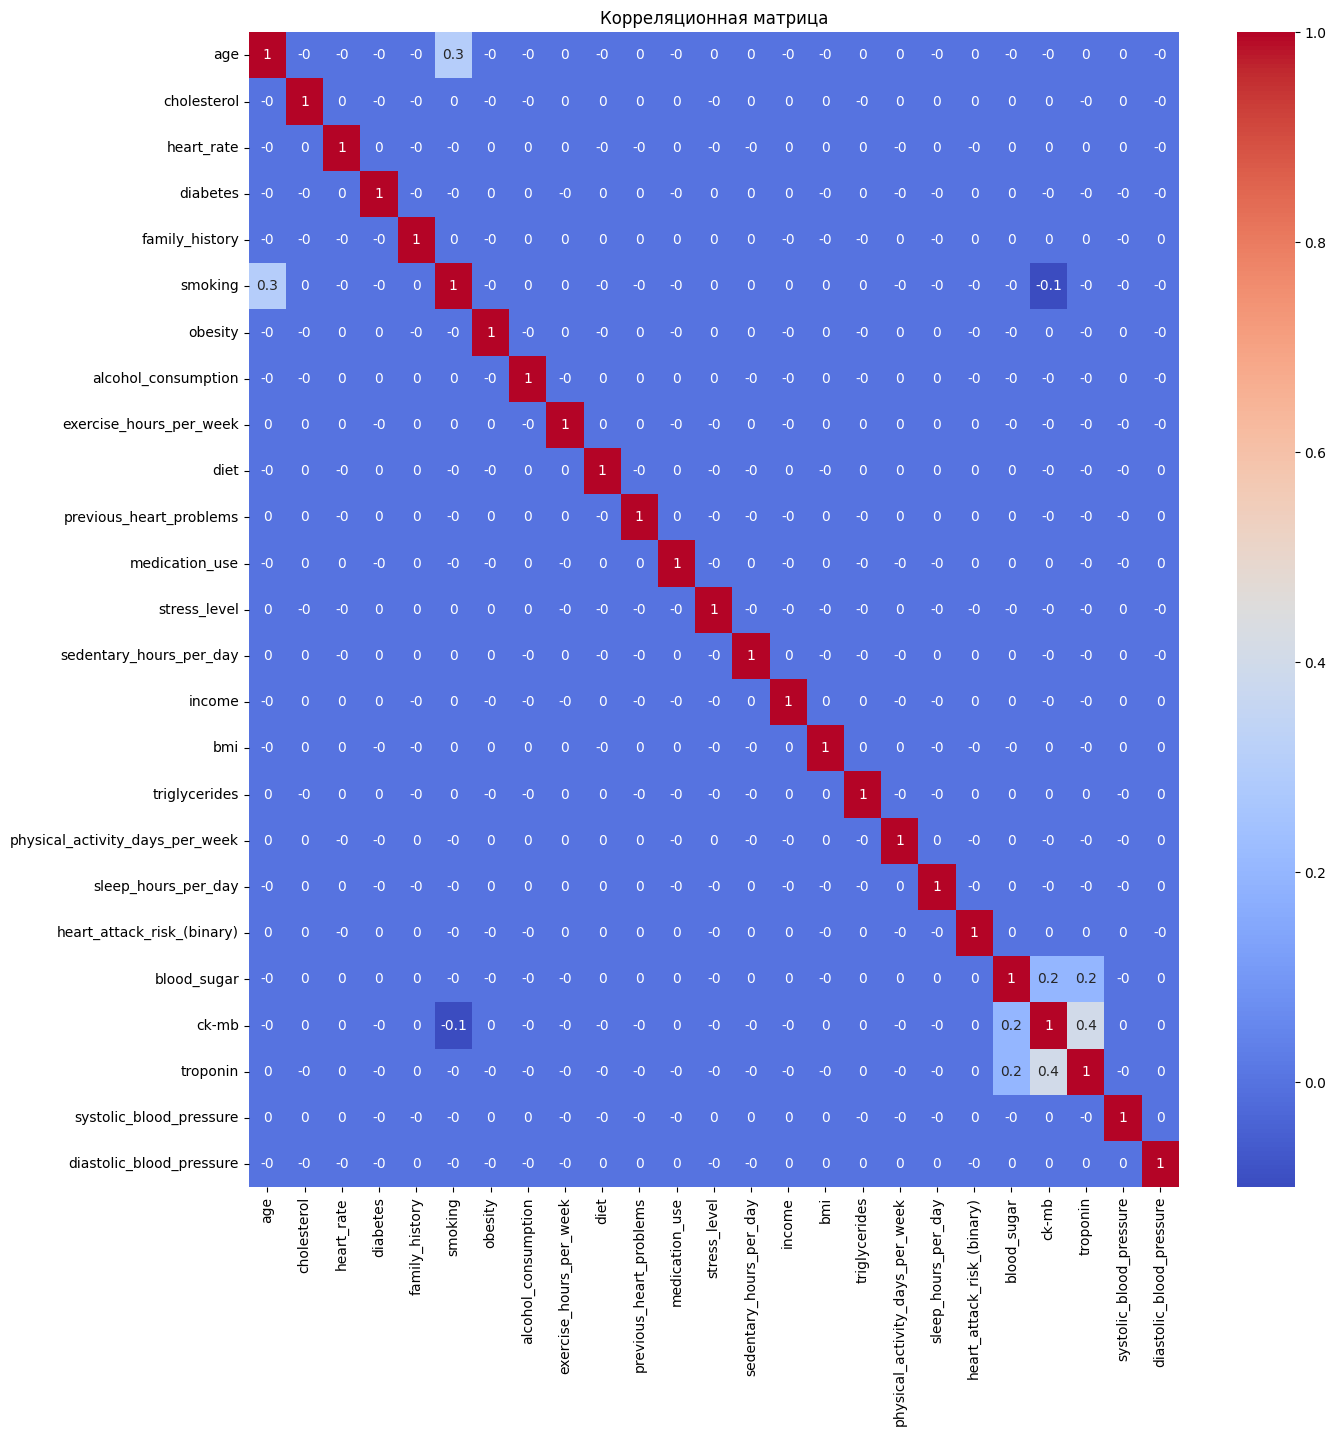


Статистика по категориальным колонкам:

Распределение значений в колонке gender:


gender
Male      5882
Female    2560
Name: count, dtype: int64

Количество уникальных значений: 2

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Информация о пропущенных значениях:


,Количество пропусков,Процент пропусков



ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ


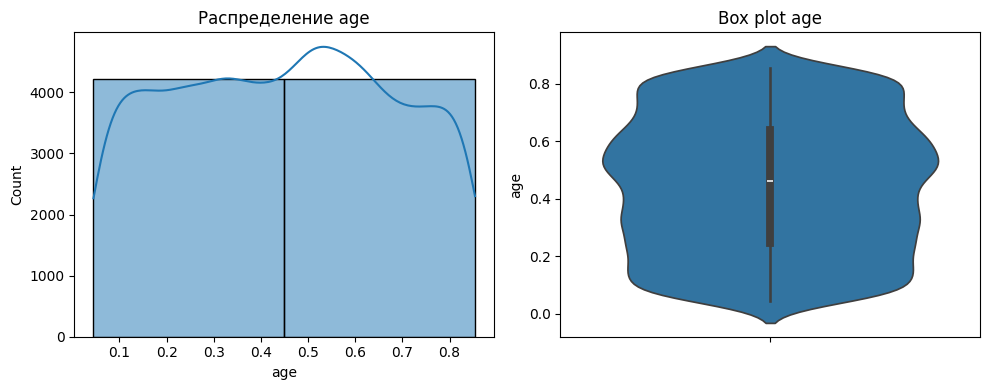

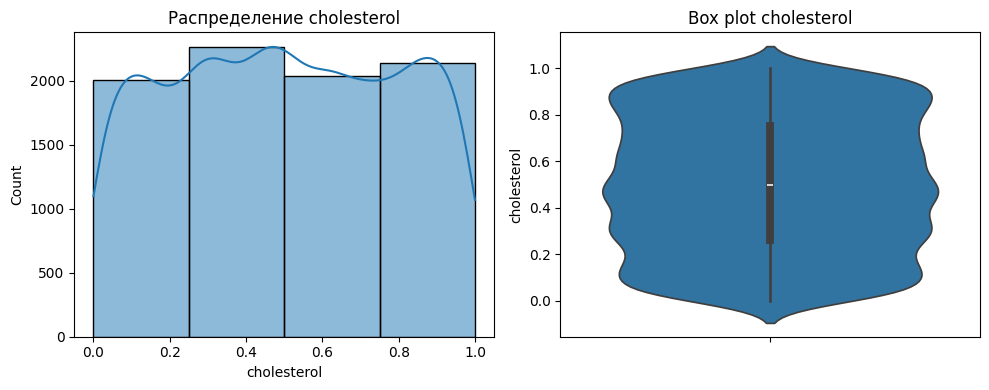

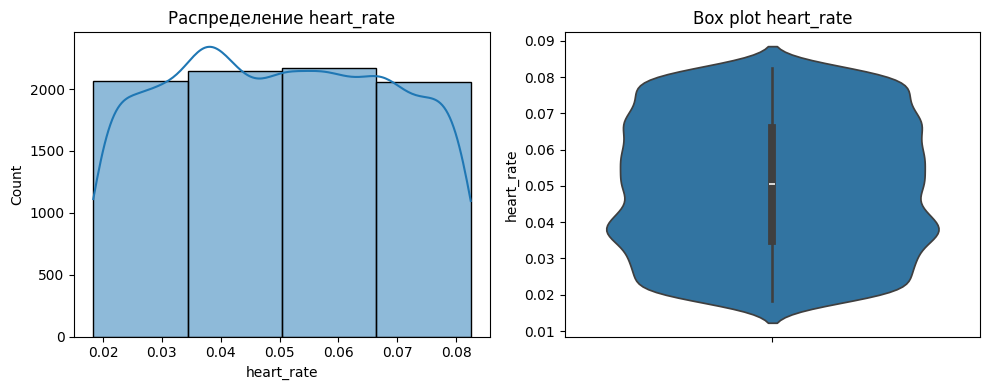

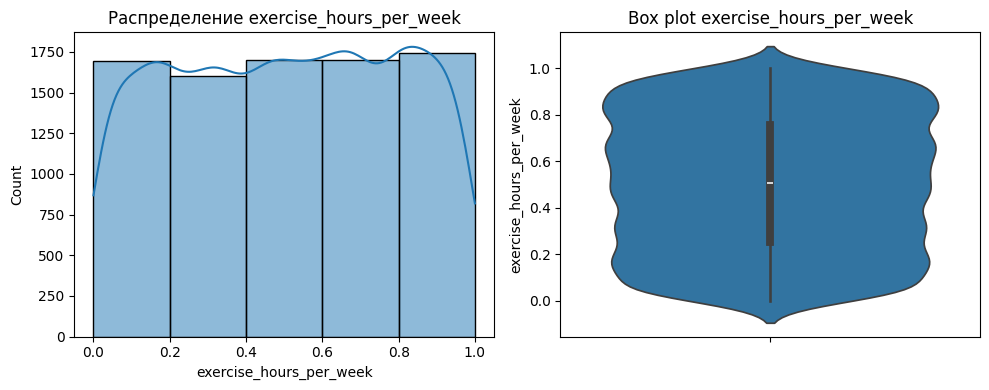

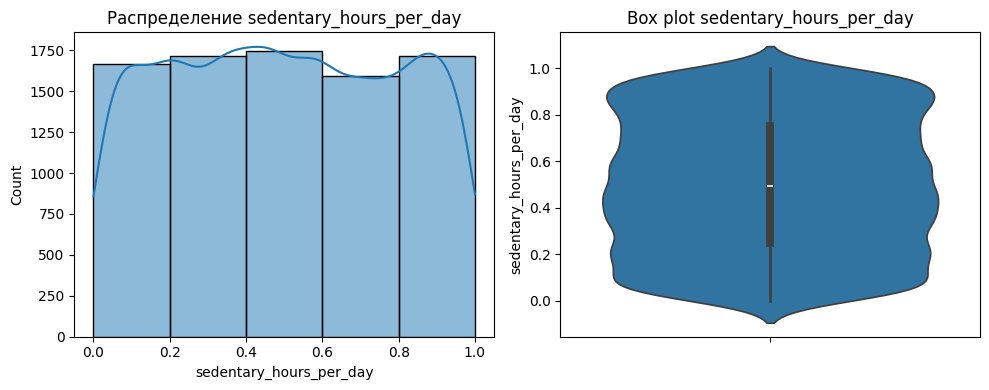

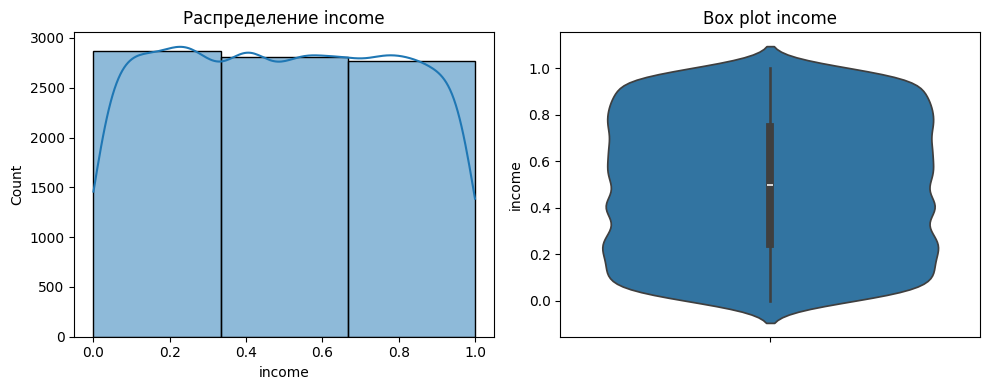

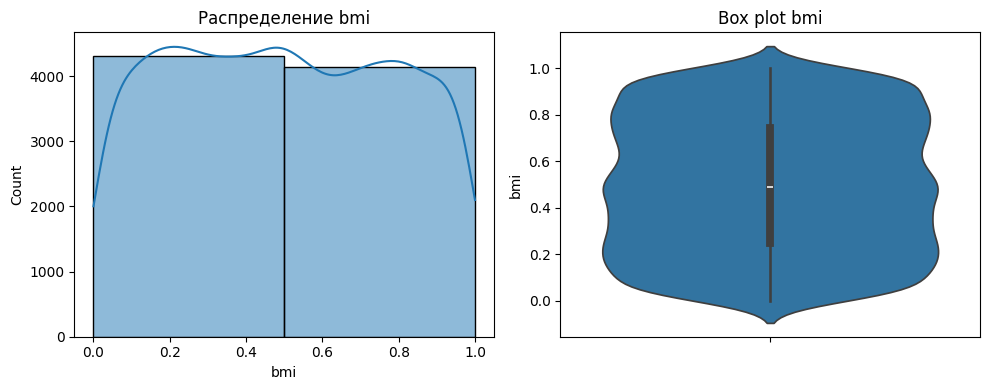

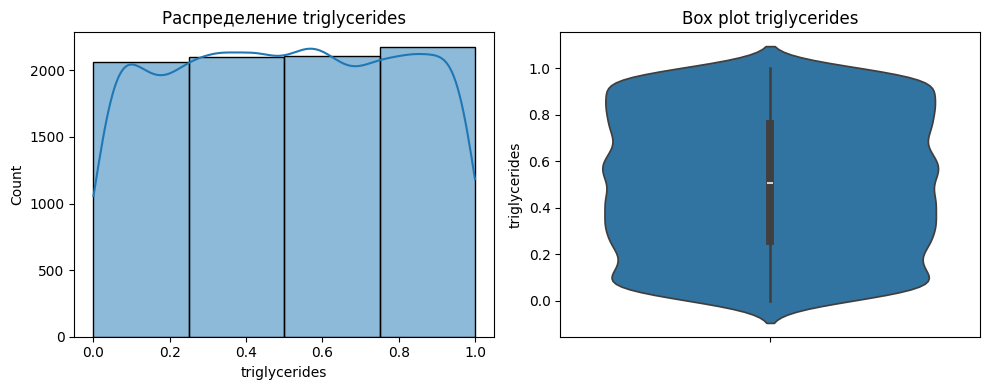

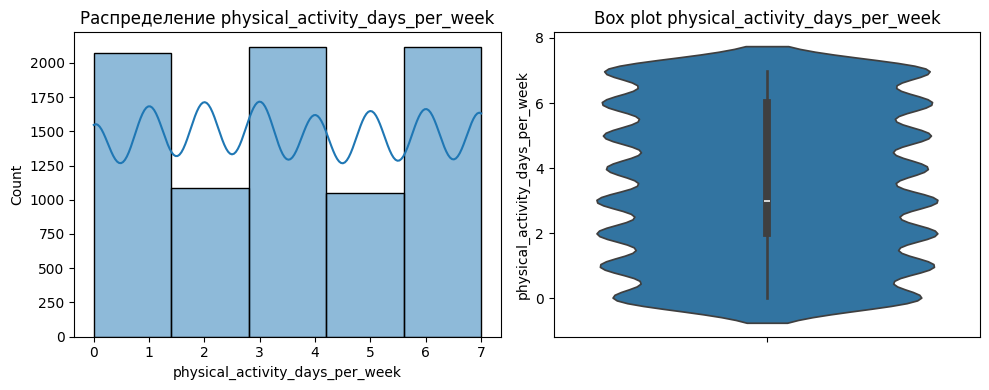

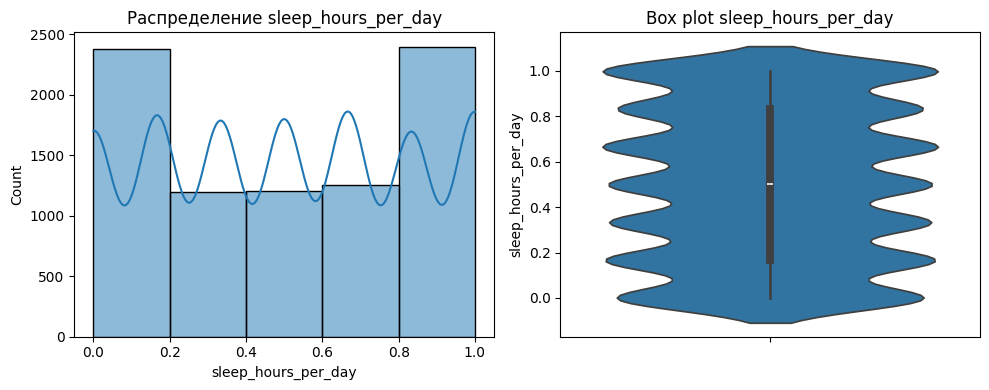

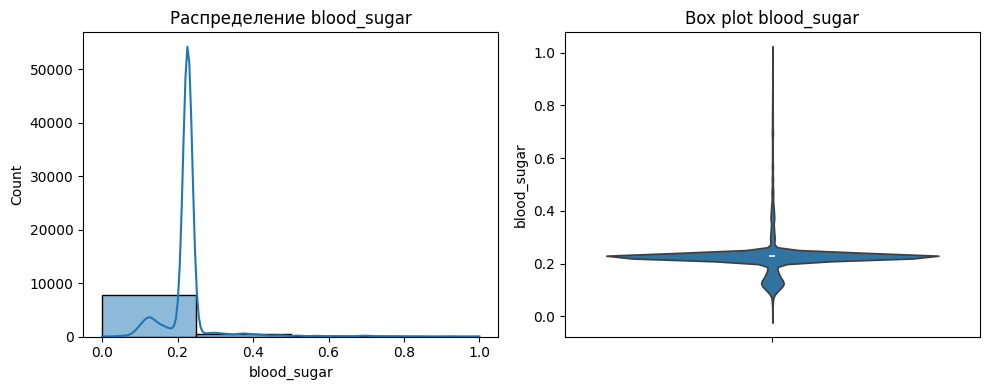

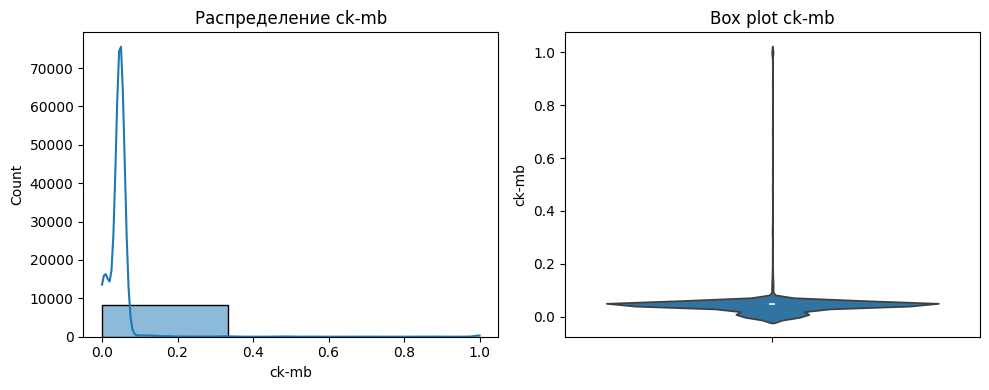

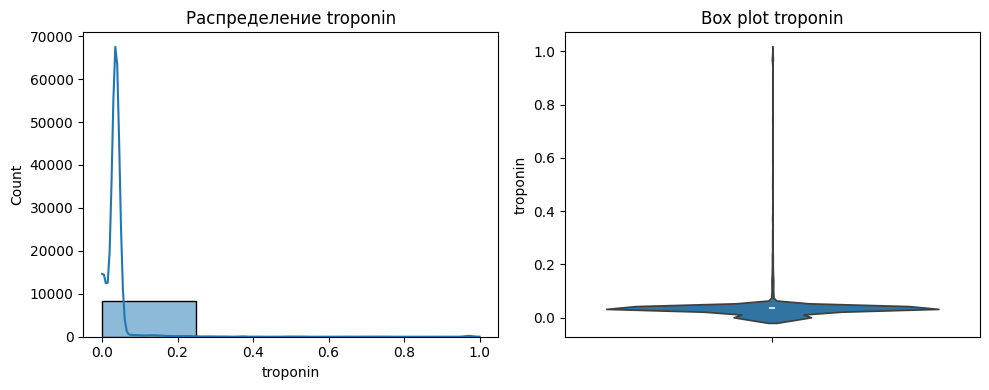

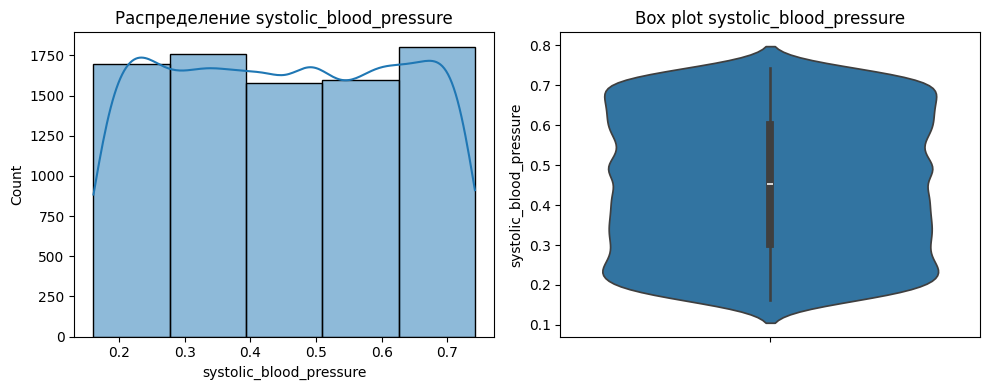

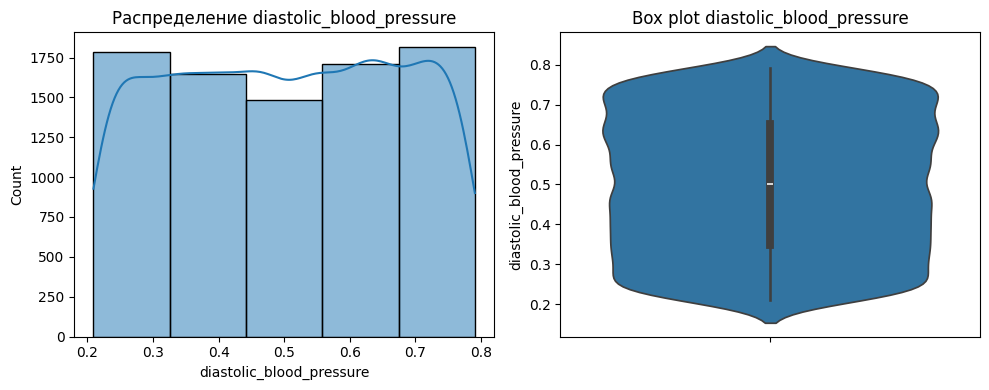

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


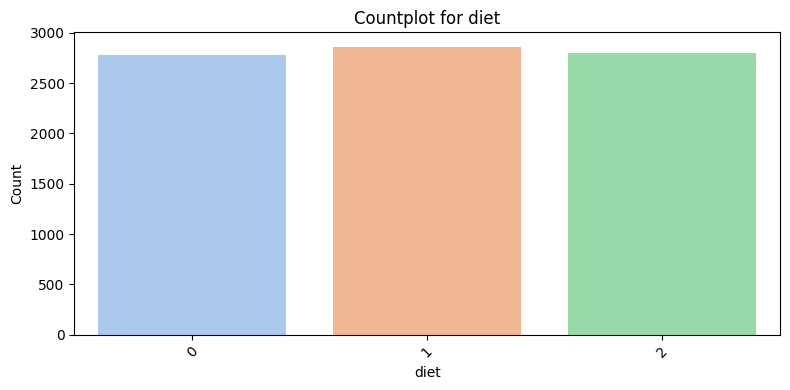

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


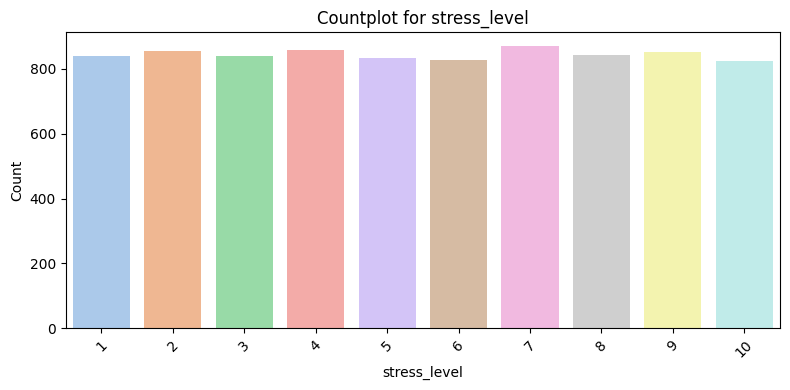

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


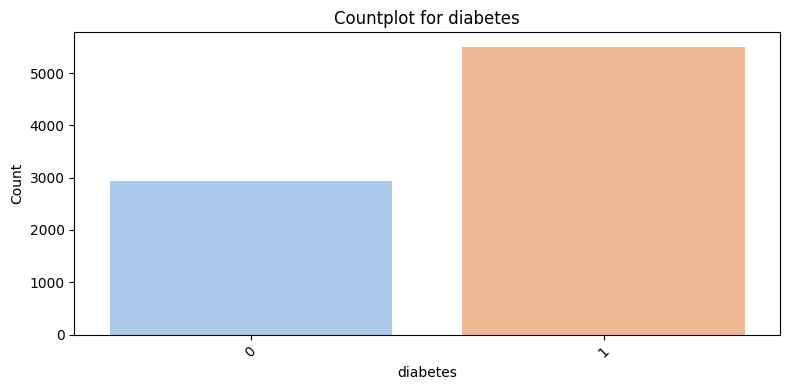

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


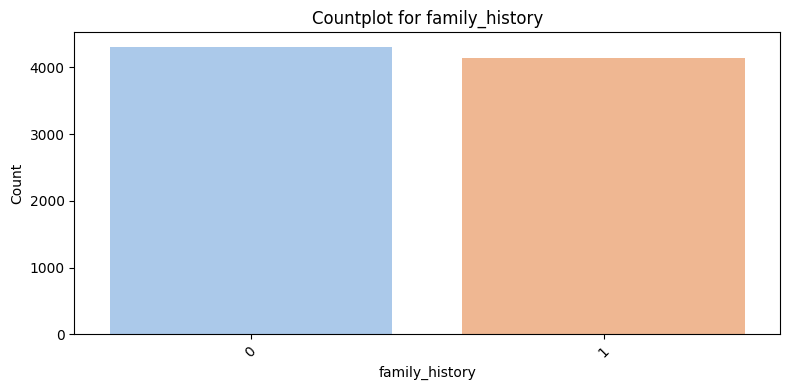

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


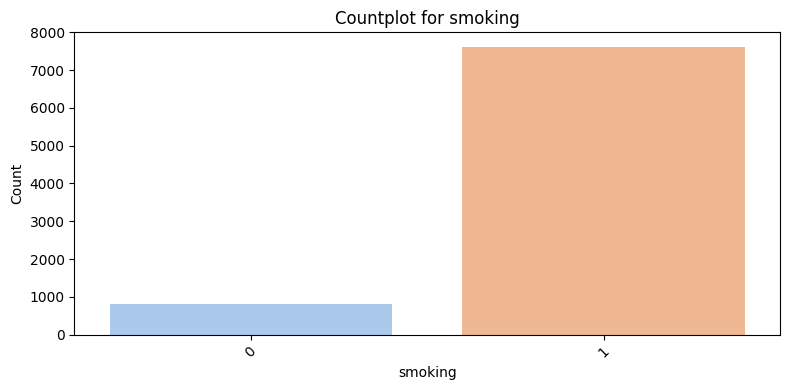

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


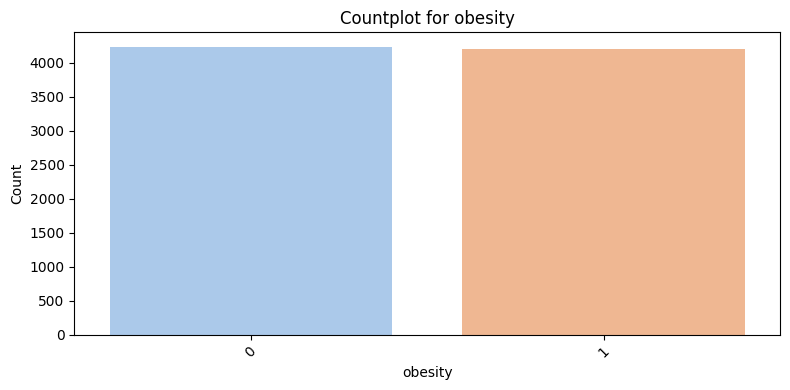

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


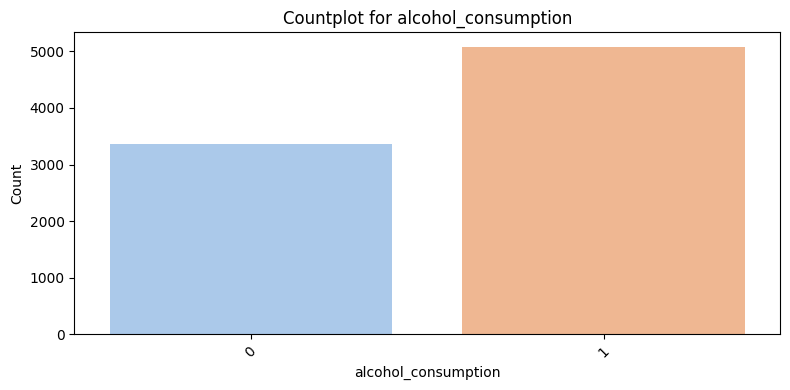

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


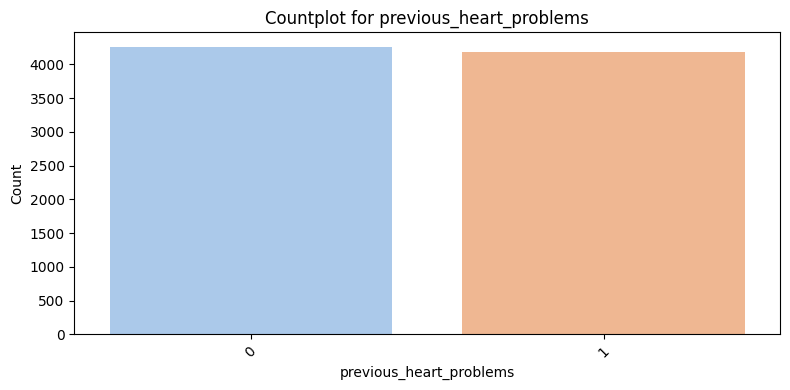

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


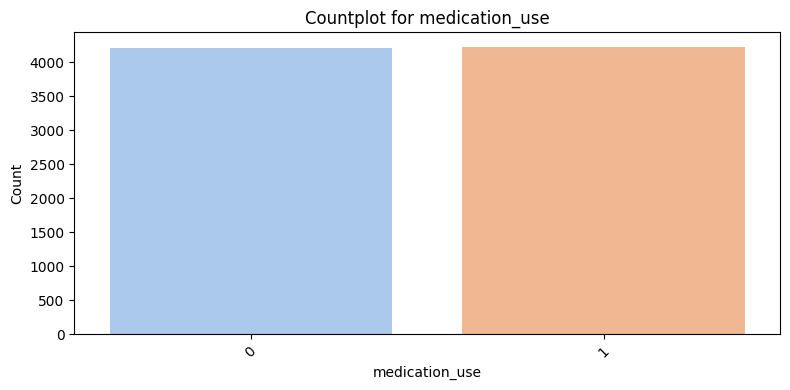

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


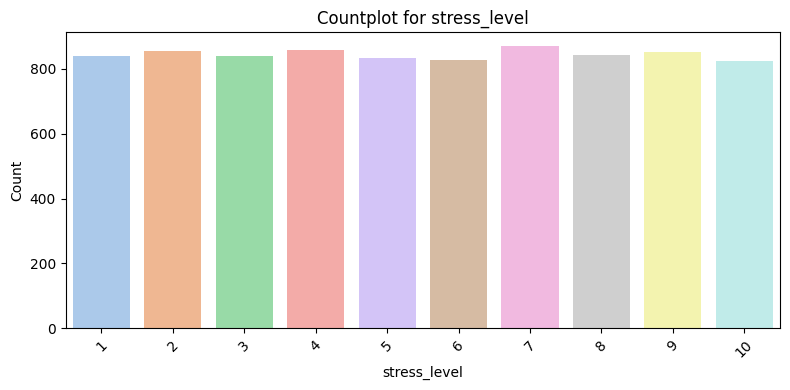

/var/folders/78/y70yls317wz28jck2vhf15mr0000gn/T/ipykernel_36514/1230724165.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel')


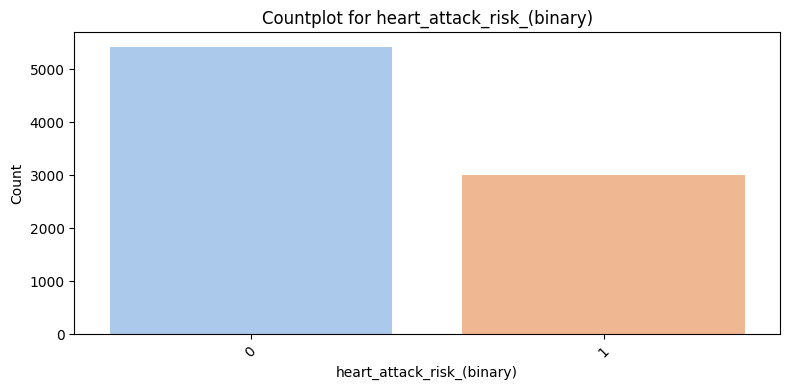

{}

In [758]:
explore_data(df.drop(columns=['id']), discrete_columns=['diet', 'stress_level','diabetes','family_history','smoking','obesity','alcohol_consumption',
                                                         'previous_heart_problems', 'medication_use','stress_level','heart_attack_risk_(binary)'])

Выявлены аномальные значения в показателях blood_sugar и troponin. Опыты показали, что удаление выбросов ухудшает качество модели, поэтому оставляем их

In [759]:
df['phys']=MinMaxScaler().fit_transform(df[['physical_activity_days_per_week']])
df = df.drop(columns=['physical_activity_days_per_week'])
df['f1'] = df['sedentary_hours_per_day']/df['exercise_hours_per_week']
df['pressure'] = df['systolic_blood_pressure']/df['diastolic_blood_pressure']

На данном этапе мы нормализовали данные по физической активности, а также добавили новые переменные

### Вывод


heart_train.csv содержит 1000+ строк и более 30 признаков.
Признаки включают:
Антропометрию: рост, вес, возраст
Привычки: курение, физическая активность, качество сна
Заболевания: диабет, гипертония и др.
Биохимия: холестерин, триглицериды, глюкоза, тропонин, CK-MB
Артериальное давление: систолическое и диастолическое
Ключевые наблюдения:

Признаки имеют пропуски, в том числе важные биомаркеры.
Найдены потенциальные признаки-утечки (тропонин, CK-MB, предыдущие жалобы и другие).
Некоторые признаки были закодированы как числа, но представляют собой категории (например, diet).



Вывод по этапу:
Данные достаточно богаты, но требуют очистки, контроля утечек и перекодировки категориальных переменных.

In [890]:



X_train, X_test, y_train, y_test = train_test_split(
      df.drop(columns=['heart_attack_risk_(binary)', 'id', 'diastolic_blood_pressure', 'exercise_hours_per_week','smoking','blood_sugar', 'previous_heart_problems', 'medication_use', 'obesity', 'diet','family_history', 'alcohol_consumption','stress_level',  'troponin','diabetes', 'ck-mb'], axis=1),
      df['heart_attack_risk_(binary)'],
      test_size = TEST_SIZE, 
      random_state = RANDOM_STATE)

cat_f = ['gender']






На данном этапе:

Удалены/закодированы признаки, вызывающие утечку (тропонин, CK-MB — опционально).
Добавлены расчетные признаки.
Удалены сильно коррелированные признаки.


In [ ]:

# Подсчёт веса для каждого класса
class_counts = np.bincount(y_train)
total = sum(class_counts)
class_weights = [total / c for c in class_counts]

print("Веса классов:", class_weights)

Веса классов: [np.float64(1.5540697674418604), np.float64(2.8048268625393495)]


In [892]:
X_train.select_dtypes(include=['int64']).columns.tolist()

[]

Опытным путем было выявлено, что наиболее подходящей моделью для прогнозирования является модель Catboost, ниже происходит подбор гиперпараметров. Также через многочисленные итерации были выявлены комбинации признаков дающие наибольщий вклад в модель (через анализ SHAP и FI)

In [893]:
param_dist = {
    'iterations': [300, 500, 800],
    'learning_rate': [0.5, 0.1, 1],
    'depth': range(1,10,2),
    'l2_leaf_reg': range(1,5),
    'border_count': [32],
    'random_strength': [1, 5],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    }

model = CatBoostClassifier(
    verbose=0,
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=cat_f,
    scale_pos_weight=2.8/1.55
)

f1_scorer = make_scorer(fbeta_score, beta=1, average='macro')

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=70,  # или больше
    scoring=f1_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train,y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x32a5eda90>,
                   n_iter=70, n_jobs=-1,
                   param_distributions={'border_count': [32],
                                        'depth': range(1, 10, 2),
                                        'grow_policy': ['SymmetricTree',
                                                        'Depthwise',
                                                        'Lossguide'],
                                        'iterations': [300, 500, 800],
                                        'l2_leaf_reg': range(1, 5),
                                        'learning_rate': [0.5, 0.1, 1],
                                        'random_strength': [1, 5]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=1, average=macro),
                   verbose=1)

In [894]:
best_model = random_search.best_estimator_
best_params = best_model.get_params()
best_score = random_search.best_score_

best_score


np.float64(0.5495270184509785)

In [903]:
best_params

{'loss_function': 'Logloss',
 'verbose': 0,
 'eval_metric': 'F1',
 'scale_pos_weight': 1.8064516129032255,
 'cat_features': ['gender'],
 'random_strength': 5,
 'learning_rate': 1,
 'l2_leaf_reg': 2,
 'iterations': 300,
 'grow_policy': 'Depthwise',
 'depth': 7,
 'border_count': 32}

In [895]:


best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)


In [899]:
threshold = 0.1

y_pred = (best_model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred_prob)



(0.8181818181818182, 0.5305263157894737, np.float64(0.5933713127021677))

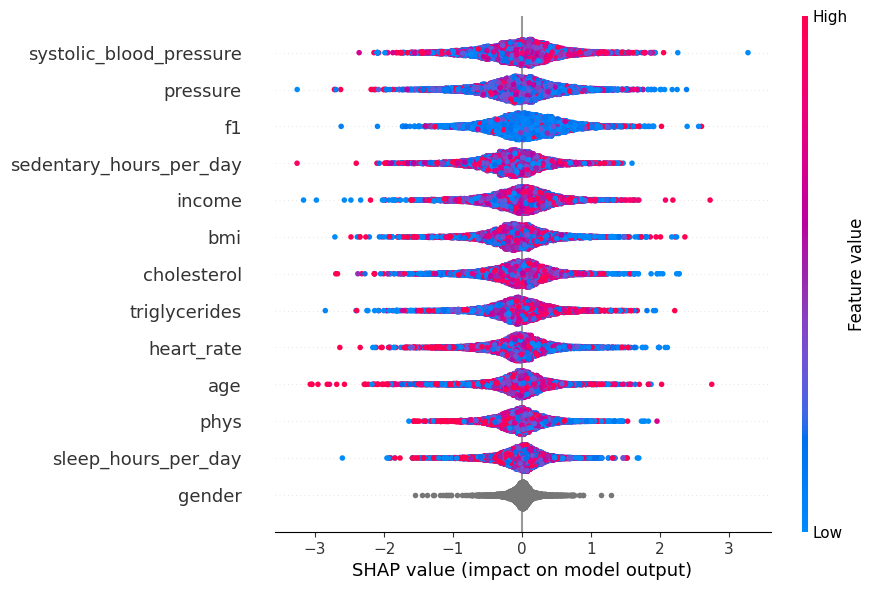

In [900]:


explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

# Визуализация
shap.plots.beeswarm(shap_values, max_display=30)

In [901]:
imp = best_model.feature_importances_
fn = X_train.columns

feat_imp = pd.DataFrame({'f': fn, 'imp':imp}).sort_values(by='imp')
feat_imp


,f,imp
8,gender,1.456962
7,sleep_hours_per_day,5.328478
10,phys,6.882171
11,f1,7.886391
4,income,7.984167
3,sedentary_hours_per_day,8.290533
12,pressure,8.356450
1,cholesterol,8.558953
6,triglycerides,8.629147
0,age,8.642713


In [902]:
best_model.save_model('heart.cbm')

## Вывод
В ходе анализа и построения модели классификации с использованием CatBoost были получены следующие ключевые результаты и наблюдения:

Качество модели и метрики
Лучший результат по метрике F1 (macro) составил около 0.55, что свидетельствует о умеренной способности модели балансировать precision и recall в условиях имеющихся данных.
При снижении порога классификации до 0.1 удалось достичь высокого recall (~0.82), однако это сопровождалось снижением общего качества модели (F1 ≈ 0.53, ROC AUC ≈ 0.59), что указывает на компромисс между полнотой и точностью предсказаний.
Значение ROC AUC близко к 0.6 указывает на то, что модель различает классы лучше случайного угадывания, но потенциал для улучшения еще есть.


Гиперпараметры модели
Оптимальные параметры включали глубину деревьев 7, 300 итераций, learning_rate = 1 и регуляризацию l2_leaf_reg = 2. При этом learning_rate оказался довольно высоким, что может приводить к менее стабильному обучению и требует дальнейшей настройки (рекомендуется снизить learning_rate и увеличить число итераций с применением ранней остановки).
Балансировка классов через параметр scale_pos_weight (≈1.8) была учтена, что положительно сказывается на чувствительности модели.


Важность признаков
Наибольший вклад в предсказание оказывают признаки, связанные с физическим состоянием и образом жизни: индекс массы тела (BMI), частота сердечных сокращений, систолическое артериальное давление, возраст, уровни триглицеридов и холестерина, а также время, проводимое в сидячем положении.
Признак «пол» (gender) имеет минимальное влияние на модель, что позволяет рассмотреть возможность его исключения для упрощения модели без потери качества.
Эти данные подтверждают значимость физиологических и поведенческих факторов при решении задачи классификации.

